# Model Initiation

In [1302]:
#Libary
import pandas as pd
import os
import numpy as np

In [1303]:
import ixmp

mp = ixmp.Platform()

In [1304]:
#convert mtoe to GWa
conv_mtoe_gwa = 11.63*1000/8760
conv_twh_gwa = 1000/8760

In [1305]:
import message_ix

scenario = message_ix.Scenario(
    mp, model='Indonesia Prototype', scenario='baseline', version='new'
)

# Functions

In [1306]:
def get_act_vtg_years(y_df,horizon,lifetimes,technology):
    """
    get active years and vintage years according to technology lifetime
    """
    for year in horizon:
        count = y_df[y_df['year_vtg'] == year]['year_vtg'].value_counts()
        count = count[year]
        if count > lifetimes[f'{technology}']:
            df = y_df[y_df['year_vtg'] == year]
            value = (count - lifetimes[f'{technology}'])*-1
            index_to_remove = df.index[value:]

            y_df = y_df.drop(index=index_to_remove)

    return y_df['year_vtg'],y_df['year_act']
            


In [1307]:
def fix_negative_values(df, fuel_col='fuel', year_col='Year', value_col='value'):
    """
    Fix negative values by transferring values within the same fuel type.
    Priority: Add to next year if exists, otherwise pull from previous years.
    
    Parameters:
    - df: pandas DataFrame
    - fuel_col: column name for fuel types
    - year_col: column name for years
    - value_col: column name for values to adjust

    Returns:
    - Adjusted DataFrame
    """
    # Sort first to ensure correct order
    df = df.sort_values(by=[fuel_col, year_col]).reset_index(drop=True)
    
    # Iterate through DataFrame
    i = 0
    while i < len(df):
        if df.loc[i, value_col] < 0:
            current_fuel = df.loc[i, fuel_col]
            
            # Try to find next year with same fuel
            next_indices = df.index[(df.index > i) & (df[fuel_col] == current_fuel)]
            
            if len(next_indices) > 0:
                next_i = next_indices[0]
                df.loc[next_i, value_col] += df.loc[i, value_col]
                df.loc[i, value_col] = 0
            else:
                # No next year: pull from previous years
                prev_indices = df.index[(df.index < i) & (df[fuel_col] == current_fuel)].tolist()
                prev_indices = prev_indices[::-1]  # Closest previous first

                for prev_i in prev_indices:
                    df.loc[i, value_col] += df.loc[prev_i, value_col]
                    df.loc[prev_i, value_col] = 0
                    if df.loc[i, value_col] >= 0:
                        break
        i += 1
    
    return df


In [1308]:
def fill_missing_values(main_df, reference_df, fuel_col='fuel', year_col='Year', value_col='value', year=2005):
    """
    Fill missing or zero values in main_df using reference_df.

    Parameters:
    - main_df: DataFrame that needs filling
    - reference_df: DataFrame providing reference values
    - fuel_col: column name for fuel types
    - year_col: column name for years
    - value_col: column name for values to adjust

    Returns:
    - Filled DataFrame
    """
    df = main_df.copy()
    
    for idx, row in df.iterrows():
        # If value is NaN or zero
        if pd.isna(row[value_col]):
            ref_value = reference_df.loc[
                (reference_df[fuel_col] == row[fuel_col]) & (reference_df[year_col] == year),
                value_col
            ]
            if not ref_value.empty:
                df.at[idx, value_col] = ref_value.values[0]
    
    return df

# Model Structure

<img src='Messageix Indonesia Structure.drawio.png' width='1000'>

In [1309]:
historical_horizon = list(range(2005,2021,5))
model_horizon = list(range(2025,2071,5))

horizon = historical_horizon+model_horizon

scenario.add_horizon(year=historical_horizon+model_horizon)


In [1310]:
country='IDN'
scenario.add_spatial_sets({'country':country})

In [1311]:
demand_com = [
    'industry_el',
    'transport_el',
    'commercial_el',
    'residential_el'
]

commodities = [
    'coal',
    'electricity',
    'gas',
    'oil',
    'biomass',
]

all_com = demand_com + commodities

In [1312]:

ppl_tec = [
    'coal_ppl',
    'gas_ppl',
    'oil_ppl',
    'hydro_ppl',
    'solar_ppl',
    'wind_ppl',
    'geo_ppl',
    'bio_ppl',
    'nuclear_ppl'
]

t_d_tec = [
    'electricity_grid'
           ]

demand_tec = [
    'industry_el_tec',
    'transport_el_tec',
    'commercial_el_tec',
    'residential_el_tec'
]

all_tec =  ppl_tec + t_d_tec + demand_tec

In [1313]:
scenario.add_set('commodity',all_com)
scenario.add_set('level',['primary','secondary','final','useful'])
scenario.add_set('technology',all_tec)
scenario.add_set('mode','standard')
scenario.add_set('level_resource','primary')
scenario.add_set('grade',['a_coal','a_gas','a_oil','a_biomass'])

## Demand Parameter

In [1314]:
path = os.getcwd()
path = os.path.dirname(path)
filename = 'COPY Indonesia AEO8 Data.xlsx'
filename = os.path.join(path,filename)

sectors = ['Industry','Transport','Commercial','Residential']
sector_models = ['industry_el','transport_el','commercial_el','residential_el']

In [1315]:
sectors

['Industry', 'Transport', 'Commercial', 'Residential']

In [1316]:
for sector,sector_model in zip(sectors,sector_models):

    df = pd.read_excel(filename,sheet_name=f'IDN_{sector}_BAS',skiprows=6)
    index = df[df['Fuel'] == 'Total'].index[0] #get index of the targeted sliced rows
    df = df.loc[:index-1]
    df = df.melt(id_vars='Fuel', value_vars=list(range(2005,2051,5)),var_name='Year')
    df = df[(df['Fuel'] == 'Electricity') & (df['Year']>2020)]
    df.value = df.value*conv_mtoe_gwa
    coeffs = np.polyfit(df["Year"].values.astype(int), df["value"].values.astype(float), deg=1)
    poly = np.poly1d(coeffs)

    # Predict values for the missing years
    future_years = list(range(2055,2071,5))
    predicted_values = poly(future_years)
    newrow = pd.DataFrame({'Year':list(range(2055,2071,5)),'Fuel':['Electricity' for _ in range(4)], 'value':predicted_values})
    df = pd.concat([df,newrow])
    values = df.value.tolist()



    df_demand = pd.DataFrame(
        {
            'node':country,
            'commodity':f'{sector_model}',
            'level':'useful',
            'year': model_horizon,
            'time':'year',
            'value':values,
            'unit':'GWa'
        }
    )

    scenario.add_par('demand',df_demand)
    

## Engineering Parameters

In [1317]:
year_df = scenario.vintage_and_active_years()
vintage_years,act_years = year_df["year_vtg"],year_df["year_act"]

In [1318]:
#Technical Lifetime (data from LEAP)
from message_ix import make_df

base_technical_lifetime = {
    'node_loc': country,
    'year_vtg':vintage_years,
    'unit':'y'
}

lifetimes ={
    'coal_ppl':40,
    'gas_ppl':30,
    'oil_ppl':40,
    'hydro_ppl':40,
    'solar_ppl':20,
    'wind_ppl':20,
    'geo_ppl':30,
    'bio_ppl':30,
    'nuclear_ppl':60
}

for tec, val in lifetimes.items():
    df = make_df(base_technical_lifetime,technology=tec,value=val)
    scenario.add_par('technical_lifetime',df)

In [1319]:
#Data from LEAP
coal_ppl_eff = 0.37 
gas_ppl_eff = 0.33 
oil_ppl_eff = 0.45 
bio_ppl_eff = 0.34
electr_grid_eff = 0.85

In [1320]:
#Coal Input

vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'coal_ppl')
base_coal_input = {
    "node_loc":country,
    "year_vtg":vintage_years,
    "year_act":act_years,
    "mode":"standard",
    "node_origin":country,
    "commodity":"coal",
    "time":"year",
    "time_origin":"year"
}

coal_ppl = pd.DataFrame(
    dict(
        technology='coal_ppl',
        level='primary',
        value=1/coal_ppl_eff,
        unit='-',
        **base_coal_input,
    )
)

#Gas Input

vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'gas_ppl')
base_gas_input = {
    "node_loc":country,
    "year_vtg":vintage_years,
    "year_act":act_years,
    "mode":"standard",
    "node_origin":country,
    "commodity":"gas",
    "time":"year",
    "time_origin":"year"
}

gas_ppl = pd.DataFrame(
    dict(
        technology='gas_ppl',
        level='primary',
        value=1/gas_ppl_eff,
        unit='-',
        **base_gas_input,
    )
)

#Oil Input

vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'oil_ppl')
base_oil_input = {
    "node_loc":country,
    "year_vtg":vintage_years,
    "year_act":act_years,
    "mode":"standard",
    "node_origin":country,
    "commodity":"oil",
    "time":"year",
    "time_origin":"year"
}

oil_ppl = pd.DataFrame(
    dict(
        technology='oil_ppl',
        level='primary',
        value=1/oil_ppl_eff,
        unit='-',
        **base_oil_input,
    )
)

#Biomass Input
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'bio_ppl')
base_bio_input = {
    "node_loc":country,
    "year_vtg":vintage_years,
    "year_act":act_years,
    "mode":"standard",
    "node_origin":country,
    "commodity":"biomass",
    "time":"year",
    "time_origin":"year"
}

bio_ppl = pd.DataFrame(
    dict(
        technology='bio_ppl',
        level='primary',
        value=1/bio_ppl_eff,
        unit='-',
        **base_bio_input,
    )
)


scenario.add_par("input",coal_ppl)
scenario.add_par("input",gas_ppl)
scenario.add_par("input",oil_ppl)
scenario.add_par("input",bio_ppl)

In [1321]:

#Electricity Input
vintage_years,act_years = pd.Series(horizon),pd.Series(horizon)
base_electr_input = {
    "node_loc":country,
    "year_vtg":vintage_years,
    "year_act":act_years,
    "mode":"standard",
    "node_origin":country,
    "commodity":"electricity",
    "time":"year",
    "time_origin":"year"
}

electr_grid = make_df(
    base_electr_input,
    technology='electricity_grid',
    level='secondary',
    value=1/electr_grid_eff,
    unit='-',
)

scenario.add_par("input",electr_grid)

for tec in demand_tec:
    electr_in = make_df(
        base_electr_input,
        technology = f'{tec}',
        level = 'final',
        value=1,
        unit ='-'
    )
    scenario.add_par('input',electr_in)
    



In [1322]:
#Output
base_output = {
'node_loc':country,
'mode':'standard',
'node_dest':country,
'time':'year',
'time_dest':'year',   
}



#coal_ppl
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'coal_ppl')
coal_ppl = make_df(
    base_output,
    technology ='coal_ppl',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'secondary',
    value = 1, 
    unit = '-'
    
)

#gas_ppl
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'gas_ppl')
gas_ppl = make_df(
    base_output,
    technology ='gas_ppl',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'secondary',
    value = 1, 
    unit = '-'  
)

#oil_ppl
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'oil_ppl')
oil_ppl = make_df(
    base_output,
    technology ='oil_ppl',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'secondary',
    value = 1, 
    unit = '-'  
)

#hydro_ppl
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'hydro_ppl')
hydro_ppl = make_df(
    base_output,
    technology ='hydro_ppl',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'secondary',
    value = 1, 
    unit = '-'  
)

#solar_ppl
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'solar_ppl')
solar_ppl = make_df(
    base_output,
    technology ='solar_ppl',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'secondary',
    value = 1, 
    unit = '-'  
)

#wind_ppl
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'wind_ppl')
wind_ppl = make_df(
    base_output,
    technology ='wind_ppl',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'secondary',
    value = 1, 
    unit = '-'  
)

#geo_ppl
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'geo_ppl')
geo_ppl = make_df(
    base_output,
    technology ='geo_ppl',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'secondary',
    value = 1, 
    unit = '-'  
)

#bio_ppl
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'bio_ppl')
bio_ppl = make_df(
    base_output,
    technology ='bio_ppl',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'secondary',
    value = 1, 
    unit = '-'  
)

#nuclear_ppl
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'nuclear_ppl')
nuclear_ppl = make_df(
    base_output,
    technology ='nuclear_ppl',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'secondary',
    value = 1, 
    unit = '-'  
)


#electricity grid
vintage_years,act_years = pd.Series(horizon),pd.Series(horizon)
electr_grid = make_df(
    base_output,
    technology ='electricity_grid',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'final',
    value = 1, 
    unit = '-'
)

for tec in ppl_tec:
    df = globals()[f'{tec}']
    scenario.add_par('output',df)
    
scenario.add_par("output",electr_grid)

for tec,com in zip(demand_tec,demand_com):
    electr_out = make_df(
        base_output,
        technology = f'{tec}',
        commodity = f'{com}',
        year_vtg = vintage_years,
        year_act = act_years,
        level = 'useful',
        value=1,
        unit ='-'
    )
    scenario.add_par('output',electr_out)

In [1323]:
#Capacity Factor (data from LEAP Max Availability)
'''
base_capacity_factor = {
    'node_loc': country,
    'time':'year',
    'unit':'-'
}

capacity_factor ={
    'coal_ppl':0.8,
    'gas_ppl':0.85,
    'oil_ppl':0.95,
    'hydro_ppl':0.55,
    'solar_ppl':0.32,
    'wind_ppl':0.2634,
    'geo_ppl':0.8,
    'bio_ppl':0.8,
    'nuclear_ppl':0.95
}

for tec, val in capacity_factor.items():
    vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,tec)
    df = make_df(
        base_capacity_factor,
        technology=tec,
        year_vtg = vintage_years,
        year_act = act_years,
        value=val)
    scenario.add_par('capacity_factor',df)'''



"\nbase_capacity_factor = {\n    'node_loc': country,\n    'time':'year',\n    'unit':'-'\n}\n\ncapacity_factor ={\n    'coal_ppl':0.8,\n    'gas_ppl':0.85,\n    'oil_ppl':0.95,\n    'hydro_ppl':0.55,\n    'solar_ppl':0.32,\n    'wind_ppl':0.2634,\n    'geo_ppl':0.8,\n    'bio_ppl':0.8,\n    'nuclear_ppl':0.95\n}\n\nfor tec, val in capacity_factor.items():\n    vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,tec)\n    df = make_df(\n        base_capacity_factor,\n        technology=tec,\n        year_vtg = vintage_years,\n        year_act = act_years,\n        value=val)\n    scenario.add_par('capacity_factor',df)"

In [1324]:
#Capacity Factor (follow historical capacity factor)
'''ppl_commodities = ['Coal','Natural Gas','Oil','Hydro','Solar PV','Wind','Geothermal','Bioenergy','Nuclear']

df_gen = pd.read_excel(filename,sheet_name='IDN_Generation_BAS',skiprows=44)[:9]
df_gen.rename(columns={'by technology - summary (TWh)':'fuel'},inplace=True)
df_gen = df_gen.melt(id_vars='fuel',value_vars=list(range(2005,2021,5)),var_name='Year')

df_cap = pd.read_excel(filename,sheet_name='IDN_Capacity_BAS',skiprows=48)[:10]
df_cap.rename(columns={'by technology - summary (GW)':'fuel'},inplace=True)
df_cap = df_cap.melt(id_vars='fuel',value_vars=list(range(2005,2021,5)),var_name='Year')
df_cap = df_cap[df_cap['fuel']!='Energy Storage']

df_cf = df_gen.merge(df_cap,on=['fuel','Year'],how='outer',suffixes=('_gen','_cap'))
df_cf['cf'] = (df_cf['value_gen']*1000/8760)/df_cf['value_cap']

capacity_factor ={
    'coal_ppl':0.85,
    'gas_ppl':0.65,
    'oil_ppl':0.85,
    'hydro_ppl':0.5877,
    'solar_ppl':0.3261,
    'wind_ppl':0.36,
    'geo_ppl':0.9,
    'bio_ppl':0.83,
    'nuclear_ppl':0.95
}

base_capacity_factor = {
    'node_loc': country,
    'time':'year',
    'unit':'-'
}

for com,tec in zip(ppl_commodities,ppl_tec):

    vintage_years,active_years = get_act_vtg_years(year_df,horizon,lifetimes,'coal_ppl')
    va_year_df = pd.DataFrame({'vintage_years':pd.Series(vintage_years),'active_years':pd.Series(active_years)})

    historical_cf = df_cf[df_cf['fuel'] == com]
    historical_cf.dropna(inplace=True)

    historical_cf = va_year_df.merge(historical_cf[['fuel','Year','cf']],left_on='active_years',right_on='Year',how='left')
    historical_cf['fuel'].fillna(com,inplace=True)
    historical_cf['cf'].fillna(capacity_factor[tec],inplace=True)

    df = make_df(
        base_capacity_factor,
        technology=tec,
        year_vtg = historical_cf['vintage_years'].tolist(),
        year_act = historical_cf['active_years'].tolist(),
        value=historical_cf['cf'].tolist())
    
    scenario.add_par('capacity_factor',df)'''

"ppl_commodities = ['Coal','Natural Gas','Oil','Hydro','Solar PV','Wind','Geothermal','Bioenergy','Nuclear']\n\ndf_gen = pd.read_excel(filename,sheet_name='IDN_Generation_BAS',skiprows=44)[:9]\ndf_gen.rename(columns={'by technology - summary (TWh)':'fuel'},inplace=True)\ndf_gen = df_gen.melt(id_vars='fuel',value_vars=list(range(2005,2021,5)),var_name='Year')\n\ndf_cap = pd.read_excel(filename,sheet_name='IDN_Capacity_BAS',skiprows=48)[:10]\ndf_cap.rename(columns={'by technology - summary (GW)':'fuel'},inplace=True)\ndf_cap = df_cap.melt(id_vars='fuel',value_vars=list(range(2005,2021,5)),var_name='Year')\ndf_cap = df_cap[df_cap['fuel']!='Energy Storage']\n\ndf_cf = df_gen.merge(df_cap,on=['fuel','Year'],how='outer',suffixes=('_gen','_cap'))\ndf_cf['cf'] = (df_cf['value_gen']*1000/8760)/df_cf['value_cap']\n\ncapacity_factor ={\n    'coal_ppl':0.85,\n    'gas_ppl':0.65,\n    'oil_ppl':0.85,\n    'hydro_ppl':0.5877,\n    'solar_ppl':0.3261,\n    'wind_ppl':0.36,\n    'geo_ppl':0.9,\n    'b

In [1325]:
#Historical Capacity Factor and 2020 to 2050 interpolated
ppl_commodities = ['Coal','Natural Gas','Oil','Hydro','Solar PV','Wind','Geothermal','Bioenergy','Nuclear']

df_gen = pd.read_excel(filename,sheet_name='IDN_Generation_BAS',skiprows=44)[:9]
df_gen.rename(columns={'by technology - summary (TWh)':'fuel'},inplace=True)
df_gen = df_gen.melt(id_vars='fuel',value_vars=list(range(2005,2021,5)),var_name='Year')

df_cap = pd.read_excel(filename,sheet_name='IDN_Capacity_BAS',skiprows=48)[:10]
df_cap.rename(columns={'by technology - summary (GW)':'fuel'},inplace=True)
df_cap = df_cap.melt(id_vars='fuel',value_vars=list(range(2005,2021,5)),var_name='Year')
df_cap = df_cap[df_cap['fuel']!='Energy Storage']

df_cf = df_gen.merge(df_cap,on=['fuel','Year'],how='outer',suffixes=('_gen','_cap'))
df_cf['cf'] = (df_cf['value_gen']*1000/8760)/df_cf['value_cap']

capacity_factor ={
    'coal_ppl':0.8, #Handayani et al. (2022) based on RUPTL 2021-2030, IEA-NEA, Mongird et al (2019)
    'gas_ppl':0.85, #Handayani et al. (2022) based on RUPTL 2021-2030, IEA-NEA, Mongird et al (2019)
    'oil_ppl':0.95, # for Fuel Oil and Diesel Power Plant, Handayani et al. (2022) based on RUPTL 2021-2030, IEA-NEA, Mongird et al (2019)
    'hydro_ppl':0.492, #Last Historical Year Value from LEAP AEO8 Calculation in 2020
    'solar_ppl':0.186, #Last Historical Year Value from LEAP AEO8 Calculation in 2022
    'wind_ppl':0.44, #Placeholder from NREL ATB 2023 - average for all wind classes (moderate)
    'geo_ppl':0.9, #Handayani et al. (2022) based on RUPTL 2021-2030, IEA-NEA, Mongird et al (2019)
    'bio_ppl':0.8, #Handayani et al. (2022) based on RUPTL 2021-2030, IEA-NEA, Mongird et al (2019)
    'nuclear_ppl':0.95 #LWR Nuclear BWRX -300 https://aris.iaea.org/PDF/BWRX-300_2020.pdf
}

base_capacity_factor = {
    'node_loc': country,
    'time':'year',
    'unit':'-'
}

for com,tec in zip(ppl_commodities,ppl_tec):
    # Step 1: Prepare year grid
    vintage_years, active_years = get_act_vtg_years(year_df, horizon, lifetimes, tec)
    va_year_df = pd.DataFrame({'vintage_years': pd.Series(vintage_years), 'active_years': pd.Series(active_years)})

    # Step 2: Extract historical CF and clean
    historical_cf = df_cf[df_cf['fuel'] == com].dropna(subset=['cf'])

    # Step 3: Get 2020 CF or use fallback
    cf_2020_vals = historical_cf.loc[historical_cf['Year'] == 2020, 'cf'].values
    cf_2020 = cf_2020_vals[0] if len(cf_2020_vals) > 0 else capacity_factor[tec]
    cf_2050 = capacity_factor[tec]

    # Step 4: Construct projected values — 2025 = 2020, interpolate to 2050
    proj_years = [2020, 2025, 2030, 2035, 2040, 2045, 2050]
    cf_proj = []
    for year in proj_years:
        if year == 2020:
            cf_proj.append(cf_2020)
        else:
            # Linear interpolation from 2025 → 2050
            interpolated = cf_2020 + (cf_2050 - cf_2020) * (year - 2020) / (2050 - 2020)
            cf_proj.append(interpolated)

    cf_future = pd.DataFrame({
        'fuel': com,
        'Year': proj_years,
        'cf': cf_proj
    })

    # Step 5: Combine historical and projected CFs
    full_cf = pd.concat([historical_cf[['fuel', 'Year', 'cf']], cf_future], ignore_index=True)

    # Step 6: Merge with vintage/active grid and fill NA with fallback
    historical_cf_merged = va_year_df.merge(full_cf, left_on='active_years', right_on='Year', how='left')
    historical_cf_merged['cf'].fillna(capacity_factor[tec], inplace=True)

    # Step 7: Create MESSAGEix-compatible DataFrame
    df = make_df(
        base_capacity_factor,
        technology=tec,
        year_vtg=historical_cf_merged['vintage_years'].tolist(),
        year_act=historical_cf_merged['active_years'].tolist(),
        value=historical_cf_merged['cf'].tolist()
    )

    # Step 8: Add to scenario
    scenario.add_par('capacity_factor', df)



C:\Users\M Ilham Rizaldi\AppData\Local\Temp\ipykernel_25104\1484608030.py:69: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  historical_cf_merged['cf'].fillna(capacity_factor[tec], inplace=True)
C:\Users\M Ilham Rizaldi\AppData\Local\Temp\ipykernel_25104\1484608030.py:69: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

In [1326]:
#Capacity Factor single value and 2025 actual value
'''ppl_commodities = ['Coal','Natural Gas','Oil','Hydro','Solar PV','Wind','Geothermal','Bioenergy','Nuclear']

df_gen = pd.read_excel(filename,sheet_name='IDN_Generation_BAS',skiprows=44)[:9]
df_gen.rename(columns={'by technology - summary (TWh)':'fuel'},inplace=True)
df_gen = df_gen.melt(id_vars='fuel',value_vars=list(range(2005,2021,5)),var_name='Year')

df_cap = pd.read_excel(filename,sheet_name='IDN_Capacity_BAS',skiprows=48)[:10]
df_cap.rename(columns={'by technology - summary (GW)':'fuel'},inplace=True)
df_cap = df_cap.melt(id_vars='fuel',value_vars=list(range(2005,2021,5)),var_name='Year')
df_cap = df_cap[df_cap['fuel']!='Energy Storage']

df_cf = df_gen.merge(df_cap,on=['fuel','Year'],how='outer',suffixes=('_gen','_cap'))
df_cf['cf'] = (df_cf['value_gen']*1000/8760)/df_cf['value_cap']

capacity_factor ={
    'coal_ppl':0.85,
    'gas_ppl':0.65,
    'oil_ppl':0.85,
    'hydro_ppl':0.5877,
    'solar_ppl':0.3261,
    'wind_ppl':0.36,
    'geo_ppl':0.9,
    'bio_ppl':0.83,
    'nuclear_ppl':0.95
}

base_capacity_factor = {
    'node_loc': country,
    'time':'year',
    'unit':'-'
}

for com,tec in zip(ppl_commodities,ppl_tec):
    # Step 1: Prepare year grid
    vintage_years, active_years = get_act_vtg_years(year_df, horizon, lifetimes, tec)
    va_year_df = pd.DataFrame({'vintage_years': pd.Series(vintage_years), 'active_years': pd.Series(active_years)})

# Step 2: Set historical years to fixed dictionary value
    historical_years = [2005, 2010, 2015, 2020]
    cf_hist = pd.DataFrame({
        'fuel': com,
        'Year': historical_years,
        'cf': capacity_factor[tec]
    })

    # Step 3: Get actual 2020 capacity factor from df_cf
    cf_2020_vals = df_cf[(df_cf['fuel'] == com) & (df_cf['Year'] == 2020)]['cf'].values
    cf_2020 = cf_2020_vals[0] if len(cf_2020_vals) > 0 else capacity_factor[tec]
    cf_2050 = capacity_factor[tec]

    # Step 4: 2025 = real 2020 CF, then interpolate to 2050
    proj_years = [2025, 2030, 2035, 2040, 2045, 2050]
    cf_proj = []
    for year in proj_years:
        if year == 2025:
            cf_proj.append(cf_2020)  # Use actual 2020 CF for 2025
        else:
            interpolated = cf_2020 + (cf_2050 - cf_2020) * (year - 2025) / (2050 - 2025)
            cf_proj.append(interpolated)

    cf_future = pd.DataFrame({
        'fuel': com,
        'Year': proj_years,
        'cf': cf_proj
    })

    # Step 5: Combine historical and projected CFs
    full_cf = pd.concat([cf_hist, cf_future], ignore_index=True)

    # Step 6: Merge with vintage/active grid
    historical_cf_merged = va_year_df.merge(full_cf, left_on='active_years', right_on='Year', how='left')
    historical_cf_merged['cf'].fillna(capacity_factor[tec], inplace=True)

    # Step 7: Create MESSAGEix-compatible DataFrame
    df = make_df(
        base_capacity_factor,
        technology=tec,
        year_vtg=historical_cf_merged['vintage_years'].tolist(),
        year_act=historical_cf_merged['active_years'].tolist(),
        value=historical_cf_merged['cf'].tolist()
    )

    # Step 8: Add to scenario
    scenario.add_par('capacity_factor', df)'''


"ppl_commodities = ['Coal','Natural Gas','Oil','Hydro','Solar PV','Wind','Geothermal','Bioenergy','Nuclear']\n\ndf_gen = pd.read_excel(filename,sheet_name='IDN_Generation_BAS',skiprows=44)[:9]\ndf_gen.rename(columns={'by technology - summary (TWh)':'fuel'},inplace=True)\ndf_gen = df_gen.melt(id_vars='fuel',value_vars=list(range(2005,2021,5)),var_name='Year')\n\ndf_cap = pd.read_excel(filename,sheet_name='IDN_Capacity_BAS',skiprows=48)[:10]\ndf_cap.rename(columns={'by technology - summary (GW)':'fuel'},inplace=True)\ndf_cap = df_cap.melt(id_vars='fuel',value_vars=list(range(2005,2021,5)),var_name='Year')\ndf_cap = df_cap[df_cap['fuel']!='Energy Storage']\n\ndf_cf = df_gen.merge(df_cap,on=['fuel','Year'],how='outer',suffixes=('_gen','_cap'))\ndf_cf['cf'] = (df_cf['value_gen']*1000/8760)/df_cf['value_cap']\n\ncapacity_factor ={\n    'coal_ppl':0.85,\n    'gas_ppl':0.65,\n    'oil_ppl':0.85,\n    'hydro_ppl':0.5877,\n    'solar_ppl':0.3261,\n    'wind_ppl':0.36,\n    'geo_ppl':0.9,\n    'b

## Technoeconomic Parameters

In [1327]:
#Resource parameters

'''Data Format
Reserves Volume (GWa)|Cost (USD/Kwa) |Historical Extraction (GWa)
'''
#Coal Energy Content 18.8 GJ/Ton
coal_reserves = 34868968.53*1000 #Tonnes Data as of December 31 2021 from US EIA
coal_reserves_gwa = coal_reserves*18.8*277.78/8760*1e-6 

coal_cost = 59.04 #USD 2020 per Metric Ton
coal_cost_kwa = coal_cost/(18.8*277.78)*8760

coal_extraction = 563728255 #Ton, Handbook of Energy and Economic Statistics of Indonesia (HEESI) 2020
coal_extraction_gwa = coal_extraction*18.8*277.78/8760*1e-6

coal_potentials = {'a':[coal_reserves_gwa,coal_cost_kwa,coal_extraction_gwa]} 

#Natural gas energy content 34.2 MJ/m3, 1 SCF = 1037 BTU
gas_reserves = 1.77*1e12 #m3
gas_reserves_gwa = gas_reserves*34.2*277.78/8760*1e-9

gas_cost = 5.56 #USD 2020 per Million BTU
gas_cost_kwa = gas_cost/(1e6*0.2931)*8760

gas_extraction = 2442831 #MMSCF, HEESI 2020
gas_extraction_gwa = gas_extraction*1.037*1e9*0.0002931/(8760*1e6)

gas_potentials = {'a':[gas_reserves_gwa,gas_cost,gas_extraction]}

#Fuel Oil Energy content 40.19 GJ/Ton, 1 BOE = 5.815 GJ
oil_reserves = 4.17*1e9 #BOE
oil_reserves_gwa = oil_reserves*5.815*277.78/(8760*1e6)

oil_cost = 6.7 #USD 2020 per barrel oil
oil_cost_kwa = oil_cost/(5.815*277.78)*8760

oil_extraction = 259247*1e3 #BBL
oil_extraction_gwa = oil_extraction*5.815*277.78/(8760*1e6)

oil_potentials = {'a':[oil_reserves,oil_cost_kwa,oil_extraction_gwa]}


bio_potentials = {'a':[2445,16.8,1.425]}  #Need to update data

In [1328]:
#Coal Resource
df = pd.DataFrame(
    {
        'node': [country],
        'commodity':'coal',
        'grade':'a_coal',
        'value':coal_potentials['a'][0],
        'unit':'GWa',
    }
)
scenario.add_par('resource_volume',df)

mp.add_unit('USD/KWa')
df = make_df(
    'resource_cost',
    node = country,
    commodity='coal',
    grade='a_coal',
    year = model_horizon,
    value=coal_potentials['a'][1],
    unit='USD/KWa'
)

scenario.add_par('resource_cost',df)

df = pd.DataFrame(
    {
        'node': country,
        'commodity':'coal',
        'grade':'a_coal',
        'year':[2020],
        'value':coal_potentials['a'][2],
        'unit':'GWa'
    }
)
scenario.add_par('historical_extraction',df)

In [1329]:
#Gas resource
df = pd.DataFrame(
    {
        'node': [country],
        'commodity':'gas',
        'grade':'a_gas',
        'value':gas_potentials['a'][0],
        'unit':'GWa',
    }
)
scenario.add_par('resource_volume',df)

mp.add_unit('USD/KWa')
df = make_df(
    'resource_cost',
    node = country,
    commodity='gas',
    grade='a_gas',
    year = model_horizon,
    value=gas_potentials['a'][1],
    unit='USD/KWa'
)

scenario.add_par('resource_cost',df)

df = pd.DataFrame(
    {
        'node': country,
        'commodity':'gas',
        'grade':'a_gas',
        'year':[2020],
        'value':gas_potentials['a'][2],
        'unit':'GWa'
    }
)
scenario.add_par('historical_extraction',df)


In [1330]:
#Oil Resource
df = pd.DataFrame(
    {
        'node': [country],
        'commodity':'oil',
        'grade':'a_oil',
        'value':oil_potentials['a'][0],
        'unit':'GWa',
    }
)
scenario.add_par('resource_volume',df)

mp.add_unit('USD/KWa')
df = make_df(
    'resource_cost',
    node = country,
    commodity='oil',
    grade='a_oil',
    year = model_horizon,
    value=oil_potentials['a'][1],
    unit='USD/KWa'
)

scenario.add_par('resource_cost',df)

df = pd.DataFrame(
    {
        'node': country,
        'commodity':'oil',
        'grade':'a_oil',
        'year':[2020],
        'value':oil_potentials['a'][2],
        'unit':'GWa'
    }
)
scenario.add_par('historical_extraction',df)


In [1331]:
#Bio Resource
df = pd.DataFrame(
    {
        'node': [country],
        'commodity':'biomass',
        'grade':'a_biomass',
        'value':bio_potentials['a'][0],
        'unit':'GWa',
    }
)
scenario.add_par('resource_volume',df)

mp.add_unit('USD/KWa')
df = make_df(
    'resource_cost',
    node = country,
    commodity='biomass',
    grade='a_biomass',
    year = model_horizon,
    value=bio_potentials['a'][1],
    unit='USD/KWa'
)

scenario.add_par('resource_cost',df)

df = pd.DataFrame(
    {
        'node': country,
        'commodity':'biomass',
        'grade':'a_biomass',
        'year':[2020],
        'value':bio_potentials['a'][2],
        'unit':'GWa'
    }
)
scenario.add_par('historical_extraction',df)

In [1332]:
#inv_cost (data from LEAP 2022)
vintage_years,act_years = year_df["year_vtg"],year_df["year_act"]
base_inv_cost = {
    'node_loc':country,
    'year_vtg':vintage_years,
    'unit':'USD/kW'
}

mp.add_unit('USD/kW')

costs = {
    'coal_ppl':1600,
    'gas_ppl':1062,
    'oil_ppl':910,
    'hydro_ppl':2200,
    'solar_ppl':960,
    'wind_ppl':1650,
    'geo_ppl':3600,
    'bio_ppl':2280,
    'nuclear_ppl':9000
}

for tec, val in costs.items():
    df = make_df(base_inv_cost,technology=tec,value=val)
    scenario.add_par('inv_cost',df)


In [1333]:
#fix_cost (data from LEAP 2022)
mp.add_unit('USD/kWa')

base_fix_cost = {
    'node_loc':country,
    'unit':'USD/kWa'
}

costs = {
    'coal_ppl':47,
    'gas_ppl':26.5,
    'oil_ppl':9.1,
    'hydro_ppl':43,
    'solar_ppl':9.2,
    'wind_ppl':40,
    'geo_ppl':18.7,
    'bio_ppl':54,
    'nuclear_ppl':127
}

for tec, val in costs.items():
    vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,tec)
    df = make_df(
        base_fix_cost,
        technology=tec,
        year_vtg = vintage_years,
        year_act = act_years,
        value=val)
    scenario.add_par('fix_cost',df)

In [1334]:
#var_cost (data from LEAP 2022)

base_var_cost = {
    'node_loc':country,
    'mode':'standard',
    'time':'year',
    'unit':'USD/kWa'
}

#in USD/MWh
costs = {
    'coal_ppl':1.5,
    'gas_ppl':2.6,
    'oil_ppl':7.3,
    'hydro_ppl':0.7,
    'solar_ppl':0,
    'wind_ppl':4.2,
    'geo_ppl':0.3,
    'bio_ppl':3.4,
    'nuclear_ppl':2.4
}

for tec, val in costs.items():
    vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,tec)
    df = make_df(
        base_var_cost,
        technology=tec,
        year_vtg = vintage_years,
        year_act = act_years,
        value=val*8760.0/1e3)
    scenario.add_par('var_cost',df)

## Calibration Parameter

In [1335]:
ppl_commodities = ['Coal','Natural Gas','Oil','Hydro','Solar PV','Wind','Geothermal','Bioenergy','Nuclear']

In [1336]:
df_gen = pd.read_excel(filename,sheet_name='IDN_Generation_BAS',skiprows=44)[:9]
df_gen.rename(columns={'by technology - summary (TWh)':'fuel'},inplace=True)
df_gen = df_gen.melt(id_vars='fuel',value_vars=list(range(2005,2021,5)),var_name='Year')

In [1337]:
df_total_gen = pd.read_excel(filename,sheet_name='IDN_Generation_BAS',skiprows=44)[:10]
df_total_gen.rename(columns={'by technology - summary (TWh)':'fuel'},inplace=True)
df_total_gen = df_total_gen[df_total_gen['fuel'] == 'Total']
df_total_gen = df_total_gen.melt(id_vars='fuel',value_vars=list(range(2005,2021,5)),var_name='Year')

In [1338]:
df_cap = pd.read_excel(filename,sheet_name='IDN_Capacity_BAS',skiprows=48)[:10]
df_cap.rename(columns={'by technology - summary (GW)':'fuel'},inplace=True)
df_cap = df_cap.melt(id_vars='fuel',value_vars=list(range(2005,2021,5)),var_name='Year')

In [1339]:
mp.add_unit("GW/y")

for act,tec in zip(ppl_commodities,ppl_tec):

    d_his = list(df_gen[df_gen['fuel'] == act]['value']*conv_twh_gwa)
    df = make_df(
        'historical_activity',
        node_loc=country,
        year_act=historical_horizon,
        mode='standard',
        time='year',
        unit='GWa',
        technology = tec,
        value = d_his
    )

    scenario.add_par('historical_activity',df)

d_his = list(df_total_gen['value']*conv_twh_gwa)
df = make_df(
    'historical_activity',
    node_loc = country,
    year_act = historical_horizon,
    mode='standard',
    time='year',
    unit='GWa',
    technology = 'electricity_grid',
    value = d_his
)

scenario.add_par('historical_activity',df)

for sector,sector_model in zip(sectors,demand_tec):

    df = pd.read_excel(filename,sheet_name=f'IDN_{sector}_BAS',skiprows=6)
    index = df[df['Fuel'] == 'Total'].index[0] #get index of the targeted sliced rows
    df = df.loc[:index-1]
    df = df.melt(id_vars='Fuel', value_vars=list(range(2005,2051,5)),var_name='Year')
    df = df[(df['Fuel'] == 'Electricity') & (df['Year']<2021)]
    df.value = df.value*conv_mtoe_gwa

    d_his = df.value.tolist()

    df = make_df(
    'historical_activity',
    node_loc = country,
    year_act = historical_horizon,
    mode='standard',
    time='year',
    unit='GWa',
    technology = sector_model,
    value = d_his
)

    scenario.add_par('historical_activity',df)





In [1340]:
mp.add_unit("GW/y")

df_cap_new = df_cap.pivot(index='Year',columns='fuel',values='value').diff().reset_index()
df_cap_new = pd.melt(df_cap_new,id_vars='Year',value_vars=ppl_commodities,value_name='value',var_name='fuel')

df_cap_new = fix_negative_values(df_cap_new,fuel_col='fuel',year_col='Year',value_col='value')
df_cap_new = fill_missing_values(df_cap_new,df_cap[df_cap['Year'] == 2005])

for cap,tec in zip(ppl_commodities,ppl_tec):
    d_his = list(df_cap_new[df_cap_new['fuel'] == cap]['value'])
    df = make_df(
        'historical_new_capacity',
        node_loc = country,
        year_vtg = historical_horizon,
        unit = 'GW/y',
        technology = tec,
        value=d_his
    )

    scenario.add_par('historical_new_capacity',df)

In [1341]:
base_growth = {
    'node_loc':country,
    'year_act':model_horizon,
    'time':'year',
    'unit':'-'
}

growth = {
    'coal_ppl':0.05,
    'gas_ppl':0.05,
    'oil_ppl':0.05,
    'hydro_ppl':0.01,
    'solar_ppl':0.01,
    'wind_ppl':0.01,
    'geo_ppl':0.01,
    'bio_ppl':0.05,
    'nuclear_ppl':0.01
}

for tec,val in growth.items():
    df = make_df(base_growth,technology = tec,value=val)
    scenario.add_par('growth_activity_up',df)


In [1342]:
base_activity = {
    'node_loc':country,
    'year_act':historical_horizon,
    'mode':'standard',
    'time':'year',
    'unit':'GWa',
}

for act,tec in zip(ppl_commodities,ppl_tec):

    d_his = df_gen
    d_his= list((d_his[d_his['fuel'] == act]['value']*conv_twh_gwa))

    df = make_df(
        base_activity,
        technology = tec,
        value = d_his
    )

    scenario.add_par('bound_activity_lo',df)
    scenario.add_par('bound_activity_up',df)


In [1343]:
'''base_activity = {
    'node_loc':country,
    'year_act':[2020],
    'mode':'standard',
    'time':'year',
    'unit':'GWa',
}

for act,tec in zip(ppl_commodities,ppl_tec):

    d_his = df_gen[df_gen['Year'] == 2020]
    d_his= list((d_his[d_his['fuel'] == act]['value']*conv_twh_gwa))

    df = make_df(
        base_activity,
        technology = tec,
        value = d_his
    )

    scenario.add_par('bound_activity_lo',df)
    scenario.add_par('bound_activity_up',df)'''


"base_activity = {\n    'node_loc':country,\n    'year_act':[2020],\n    'mode':'standard',\n    'time':'year',\n    'unit':'GWa',\n}\n\nfor act,tec in zip(ppl_commodities,ppl_tec):\n\n    d_his = df_gen[df_gen['Year'] == 2020]\n    d_his= list((d_his[d_his['fuel'] == act]['value']*conv_twh_gwa))\n\n    df = make_df(\n        base_activity,\n        technology = tec,\n        value = d_his\n    )\n\n    scenario.add_par('bound_activity_lo',df)\n    scenario.add_par('bound_activity_up',df)"

## Emission

In [1344]:
scenario.add_set("emission", "CO2")
scenario.add_cat("emission", "GHGs", "CO2")

In [1345]:
base_emissions = {
    "node_loc": country,
    "year_vtg": vintage_years,
    "year_act": act_years,
    "mode": "standard",
    "unit": "tCO2/kWa",
}

# adding new units to the model library (needed only once)
mp.add_unit("tCO2/kWa")
mp.add_unit("MtCO2")

emissions = {
    "coal_ppl": ("CO2", 0.854),  # units: tCO2/MWh
    "gas_ppl": ("CO2", 0.339),  # units: tCO2/MWh
    "oil_ppl": ("CO2", 0.57),  # units: tCO2/MWh
}

for tec, (species, val) in emissions.items():
    df = make_df(
        base_emissions, technology=tec, emission=species, value=val * 8760.0 / 1000
    )  # to convert tCO2/MWh into tCO2/kWa
    scenario.add_par("emission_factor", df)


## Objective Function

In [1346]:
scenario.add_par("interestrate", model_horizon, value=0.07, unit="-")

# Commit and Solve the Model

In [1347]:
comment = "initial commit for Indonesia model"
scenario.commit(comment)
scenario.set_as_default()

In [1348]:
scenario.solve()

In [1349]:
scenario.var("OBJ")["lvl"]


394634.875

# Plotting Result

In [1350]:
%matplotlib inline


In [1351]:
from message_ix.report import Reporter
from message_ix.util.tutorial import prepare_plots

# Create a Reporter object to describe and carry out reporting
# calculations and operations (like plotting) based on `scenario`
rep = Reporter.from_scenario(scenario)

# "prepare_plots" enables several to describe reporting operations, e.g.
# "plot activity", "plot capacity", or "plot prices"
# See message_ix/util/tutorial.py for more information
prepare_plots(rep)

<Axes: title={'center': 'IDN Energy System Activity'}, xlabel='Year', ylabel='GWa'>

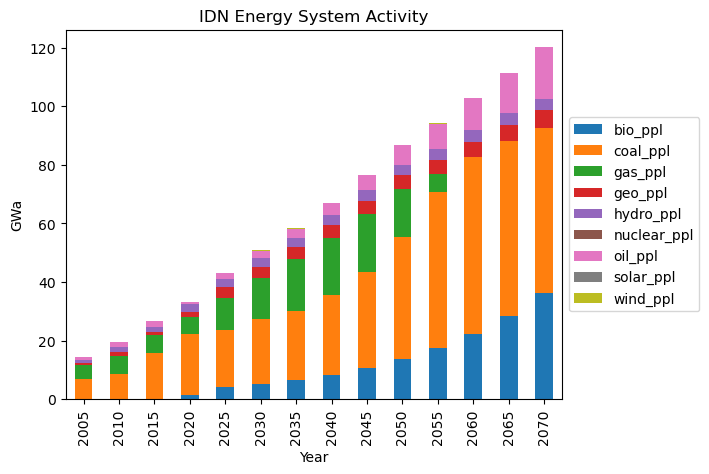

In [1352]:
rep.set_filters(t=ppl_tec, ya=historical_horizon+model_horizon)
rep.get("plot activity")



<Axes: title={'center': 'IDN Energy System Capacity'}, xlabel='Year', ylabel='GW'>

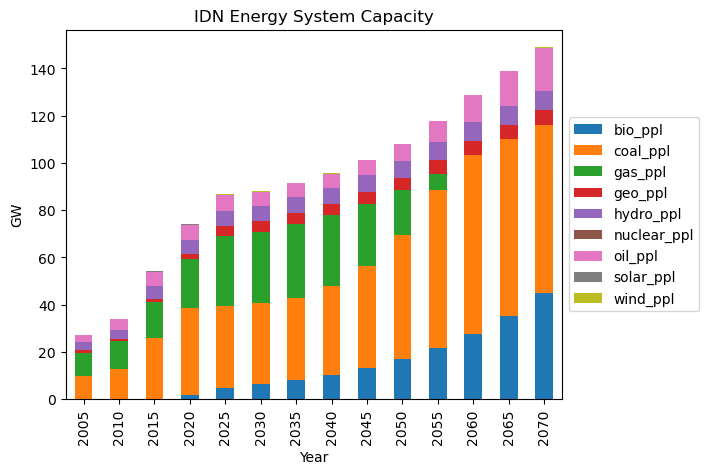

In [1353]:
rep.get('plot capacity')

<Axes: title={'center': 'IDN Fossil Supply'}, xlabel='Resource volume [GWa]', ylabel='Cost [USD / KWa]'>

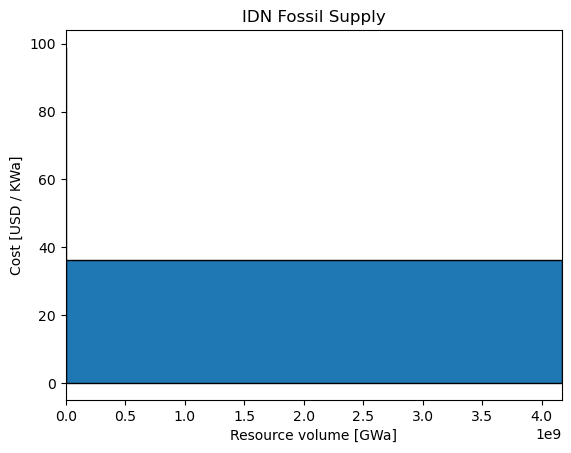

In [1354]:
rep.set_filters()
rep.get("plot fossil supply curve")


<Axes: title={'center': 'g\n    IDN\nName: 0, dtype: object Energy System Extraction'}, xlabel='Year', ylabel='GW'>

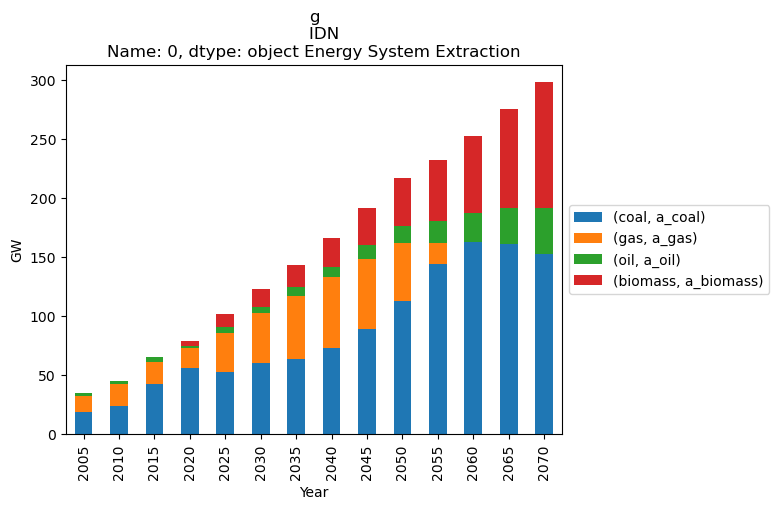

In [1355]:
rep.set_filters()
rep.get("plot extraction")


<Axes: title={'center': 'IDN Energy System Demand'}, xlabel='Year', ylabel='GWa'>

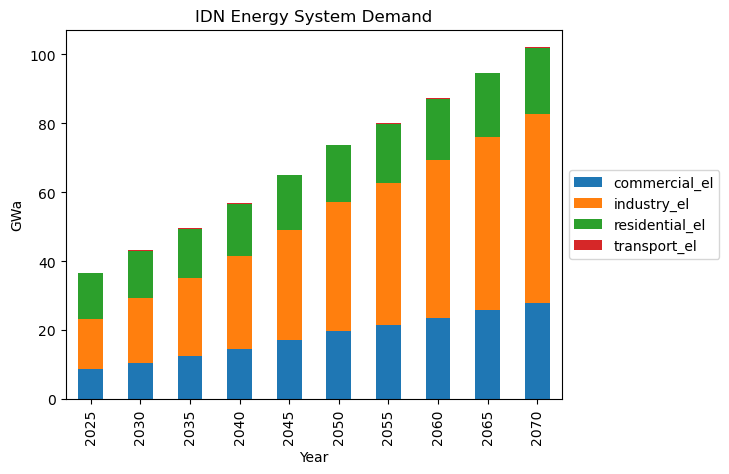

In [1356]:
rep.get('plot demand')

In [1357]:
scenario.remove_solution()

In [1358]:
scenario.check_out()

In [1359]:
mp.close_db()